## **Specialization Module: Python for Data Analytics**


---



# **Parameters**

*  **Task**: To analyze data with Python and create a notebook, where to show the Python and analytical skills
*  **Ask**: On which customer groups should the marketing team focus?
*  **Requestor (POC)**: Turing College
*  **Data Source**: Internal data tc-da-1.turing_data_analytics.rfm (BigQuery)
*  **Metrics**: Listed below in the EDA part of the analysis
*  **Territory**: All countries
*  **Time Period**: From 2010-12-01 to 2011-12-09
*  **Outcome**: Google Colab notebook with EDA and visualizations using Python libraries
*  **Deadline**: 08.05.2024
*  **Delivered**: 16.04.2024



---




# **RFM Analysis**


**RFM** stands for Recency, Frequency, and Monetary value. It's a powerful method for categorizing and understanding the customer base based on their transaction history and common characteristics - how recently, how often and how much they buy.

**Customer segmentation** is beneficial in marketing campaigns, identifying potentially profitable customers and developing customer loyalty. It helps to gain deeper knowledge of customers and tailor targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

The goal of this analysis is to identify customer segments for a given dataset using RFM analysis and to understand how those groups differ from each other.




In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

!pip install inflection
import inflection # for performing string transformation tasks

pd.options.display.float_format = '{:,.1f}'.format # for displaying floating-point numbers with one decimal place by default

In [192]:
# Accessing BigQuery Datasets using Google Colab
from google.colab import auth
auth.authenticate_user()
#print('Authenticated')

In [193]:
# Setting up a connection to Google BigQuery and accessing a specific dataset within it
project_id = 'tc-da-1'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)
dataset_ref = client.dataset("turing_data_analytics", project = project_id)
dataset = client.get_dataset(dataset_ref)

In [194]:
tables = list(client.list_tables(dataset))

for table in tables:
  print(table.table_id)

adsense_monthly
bank_loans_data
bank_loans_stats
raw_events
rfm
rfm_quantiles
rfm_score
rfm_value
stackoverflow_posts
subscriptions


In [195]:
# Accessing 'rfm' table
sql_table_id = tables[4]
sql_table_id

# Loading Data to a Dataframe
rfm_df = client.list_rows(sql_table_id).to_dataframe()

**Data Exploration**


---



In this step, I explore the dataset, understanding its size, the types of variables it contains and gaining a sense of the data distribution.

In [196]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   InvoiceNo    541909 non-null  object             
 1   StockCode    541909 non-null  object             
 2   Description  540455 non-null  object             
 3   Quantity     541909 non-null  Int64              
 4   InvoiceDate  541909 non-null  datetime64[us, UTC]
 5   UnitPrice    541909 non-null  float64            
 6   CustomerID   406829 non-null  Int64              
 7   Country      541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


Attribute information:

* **InvoiceNo**: A number uniquely assigned to each transaction.
* **StockCode**: A number uniquely assigned to each distinct product.
* **Description**: Product name.
* **Quantity**: The quantity of each product sold per invoice.
* **InvoiceDate**: Invoice date and time.
* **UnitPrice**: Product price per unit.
* **CustomerID**: A number uniquely assigned to each customer.
* **Country**: Country of purchase.



What's observed here:

There are missing values in some rows of the 'CustomerID' and 'Description' columns, as indicated by the difference in row counts compared to other columns. I'll investigate this further later.

In [197]:
rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,"541,909.0",9.6,218.1,"-80,995.0",1.0,3.0,10.0,"80,995.0"
UnitPrice,"541,909.0",4.6,96.8,"-11,062.1",1.2,2.1,4.1,"38,970.0"
CustomerID,"406,829.0","15,287.7","1,713.6","12,346.0","13,953.0","15,152.0","16,791.0","18,287.0"


What's observed here:

The 'Quantity' and 'UnitPrice' columns contain negative values. I'll investigate this further later.

In [198]:
# Converting the column names to snake_case
rfm_df.columns = [inflection.underscore(col) for col in rfm_df.columns]

In [199]:
rfm_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536544,22081,RIBBON REEL FLORA + FAUNA,1,2010-12-01 14:32:00+00:00,3.4,<NA>,United Kingdom
2,536544,22100,SKULLS SQUARE TISSUE BOX,1,2010-12-01 14:32:00+00:00,2.5,<NA>,United Kingdom
3,536544,22114,HOT WATER BOTTLE TEA AND SYMPATHY,3,2010-12-01 14:32:00+00:00,8.5,<NA>,United Kingdom
4,536544,22196,SMALL HEART MEASURING SPOONS,2,2010-12-01 14:32:00+00:00,1.7,<NA>,United Kingdom


There are missing vaues (NA) in the 'customer_id' column as was discovered earlier.

**Data Cleaning**


---



I'm going to check the dataset for:
* Duplicate records
* Obviously wrong values
* Missing values



*   Duplicate records


In [200]:
print('Duplicate entries: {}'.format(rfm_df.duplicated().sum()))
print('{}% rows are duplicate'.format(round((rfm_df.duplicated().sum()/rfm_df.shape[0])*100),2))

rfm_df.drop_duplicates(inplace = True)

Duplicate entries: 5268
1% rows are duplicate


There are 5268 duplicate entries (1% of the dataset). I have removed these duplicates from the dataset.

*   Obviously wrong values

In [201]:
print("Rows with zero or negative quantity:", rfm_df[rfm_df['quantity'] <= 0 ]['quantity'].count(),
      '|',
      round(len(rfm_df[rfm_df['quantity']<=0])/len(rfm_df)*100, 2),"%")
print("Rows with zero or negative unit price:", rfm_df[rfm_df['unit_price'] <= 0 ]['unit_price'].count(),
      '|',
      round(len(rfm_df[rfm_df['unit_price']<=0])/len(rfm_df)*100, 2),"%")

Rows with zero or negative quantity: 10587 | 1.97 %
Rows with zero or negative unit price: 2512 | 0.47 %


Records with zero or negative 'quantity' or 'unit_price' are likely refunds or promotional items. I'm going to remove them later because otherwise, they will distort the monetary metric and skew its distribution.


*   Missing values

In [202]:
missing_values = rfm_df.isnull().sum()
print(missing_values)

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135037
country              0
dtype: int64


As expected, the 'customer_id' and 'description' columns contain missing values. Invoices without a Customer Id were likely created without autorization. I'm going to remove them from my analysis because otherwise, they will skew the distribution of RFM metrics.

I also don't need the product description in my analysis, so I plan to eliminate 'description' column later on.








In [203]:
rfm_df = rfm_df[pd.notnull(rfm_df['customer_id'])]

In [204]:
#missing_values = rfm_df.isnull().sum()
#print(missing_values)

In [205]:
#rfm_df.head()

There are no missing values in the data anymore.



I'm checking which data period is covered in this dataset:

In [206]:
print('From: {} \nTo:   {}'.format(rfm_df['invoice_date'].min(),
                                   rfm_df['invoice_date'].max()))

From: 2010-12-01 08:26:00+00:00 
To:   2011-12-09 12:50:00+00:00


I'm going to define a reference date as a one day after the last purchase. The reference date will be used in calculating recency later.

In [207]:
reference_date = rfm_df['invoice_date'].max() + pd.DateOffset(days=1)
reference_date = reference_date.strftime('%Y-%m-%d')

print("Reference date:", reference_date)

Reference date: 2011-12-10


The dataset consists of approximately one year of data. A one-year timeframe is commonly used in RFM analysis. I'll set the period to cover one year.

Additionally, I will filter the data to exclude rows with zero or negative 'quantity' or zero or negative 'unit_price', as mentioned above.


In [208]:
start_date = '2010-12-01'
end_date = '2011-12-02'

rfm_df = rfm_df[(rfm_df['quantity'] > 0) & (rfm_df['unit_price'] > 0) &
                (rfm_df['invoice_date'].between(start_date, end_date))]

In [209]:
#rfm_df.info()

As a result, there are no zero or negative values for the 'quantity' and 'unit_price' columns anymore.

In [210]:
rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,"377,786.0",12.9,128.2,1.0,2.0,6.0,12.0,"74,215.0"
unit_price,"377,786.0",3.1,22.5,0.0,1.2,1.9,3.8,"8,142.8"
customer_id,"377,786.0","15,287.6","1,713.0","12,346.0","13,956.0","15,152.0","16,790.0","18,287.0"


In [211]:
#rfm_df['unit_price'].min()

I'm going to check the number of unique customers and the combinations of customer-country.

In [212]:
distinct_customers = rfm_df['customer_id'].nunique()
print("Distinct CustomerID:", distinct_customers)

summary = f"Distinct CustomerID-Country: {rfm_df[['customer_id', 'country']].drop_duplicates().shape[0]}"
print(summary)

Distinct CustomerID: 4300
Distinct CustomerID-Country: 4308


These are the columns I'm going to use in further analysis.

In [213]:
rfm_df = rfm_df[['customer_id','country','invoice_date','invoice_no','quantity','unit_price']]

I'm adding the new column 'total_sales' to calculate the amount of sales by multiplying quantity and unit price.

In [214]:
rfm_df = rfm_df.copy()
rfm_df.loc[:, 'total_sales'] = rfm_df['quantity'] * rfm_df['unit_price']
#print(rfm_df.columns)

I want to check which country has a higher customer base, number of orders, quantity and sales amount.

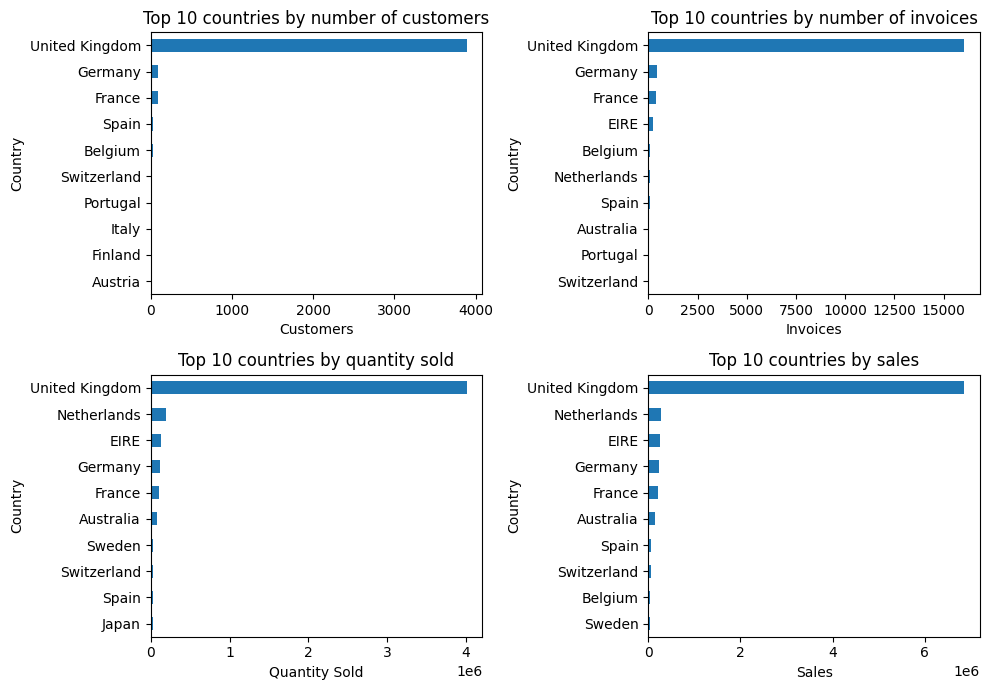

In [215]:
top_10_countries_customers = rfm_df.groupby('country')['customer_id'].nunique().nlargest(10)
top_10_countries_invoices = rfm_df.groupby('country')['invoice_no'].nunique().nlargest(10)
top_10_countries_quantity = rfm_df.groupby('country')['quantity'].sum().nlargest(10)
top_10_countries_sales = rfm_df.groupby('country')['total_sales'].sum().nlargest(10)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))

plots = [
    ('Top 10 countries by number of customers', top_10_countries_customers),
    ('Top 10 countries by number of invoices', top_10_countries_invoices),
    ('Top 10 countries by quantity sold', top_10_countries_quantity),
    ('Top 10 countries by sales', top_10_countries_sales)
]

for i, (title, data) in enumerate(plots):
    ax = axes[i // 2, i % 2]  # Getting current subplot ('i // 2 calculates the row index, 'i % 2' - the column index)
    data.sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Customers' if 'customers' in title else ('Invoices' if 'invoices' in title else ('Quantity Sold' if 'quantity' in title else 'Sales')))
    ax.set_ylabel('Country')

plt.tight_layout()
plt.show()

What's observed here:

The dominant market is the United Kingdom with the highest number of customers, orders, quantity sold and sales amount.

**Recency, Frequency, Monetary**


---




RFM model combines three different customer attributes to rank customers:

* **Recency** (R): Number of days since the last purchase.
* **Frequency** (F): Number of purchases during the analyzed period (usually one year).
* **Monetary** (M): Total amount of purchases made during the studied period.


To get the RFM score of a customer, I first need to calculate the R, F and M scores on a scale from 1 (worst) to 4 (best).

The steps are:

1. Calculate Recency
2. Calculate Freqency
3. Calculate Monetary
4. Find quintiles for each of these metrics
5. Assign a score to each metric depending on which quintile it falls into
6. Combine R, F and M scores to get the RFM score
7. Map RFM scores to segments








First, I need to group the data by 'customer_id' and 'country'.

- For **recency**, I’ll calculate the difference between the reference date and the maximum (most recent) invoice date for each customer. This will give me the number of days since the last purchase, where smaller values indicate that a customer has made a purchase more recently.
- Since **frequency** measures how often a customer makes purchases, I’ll calculate it as the total number of unique invoices made by each customer.
- **Monetary value** calculates how much money a customer spends, so I’ll find the total monetary value for each customer.

In [216]:
rfm = rfm_df.groupby(['customer_id', 'country']).agg({'invoice_date': lambda date: (pd.Timestamp(reference_date) - date.max().tz_localize(None)).days, # Recency: days since the last order
                                                      'invoice_no': 'nunique', # Frequency: total number of orders
                                                      'total_sales': 'sum' # Monetary: total sales
                                                     })
# Renaming the columns for readability
rfm.columns =['recency', 'frequency', 'monetary']
#rfm.head()

In [217]:
#rfm.describe().T

Let's examine the distributions of recency, frequency and monetary values.
I'll plot the data.

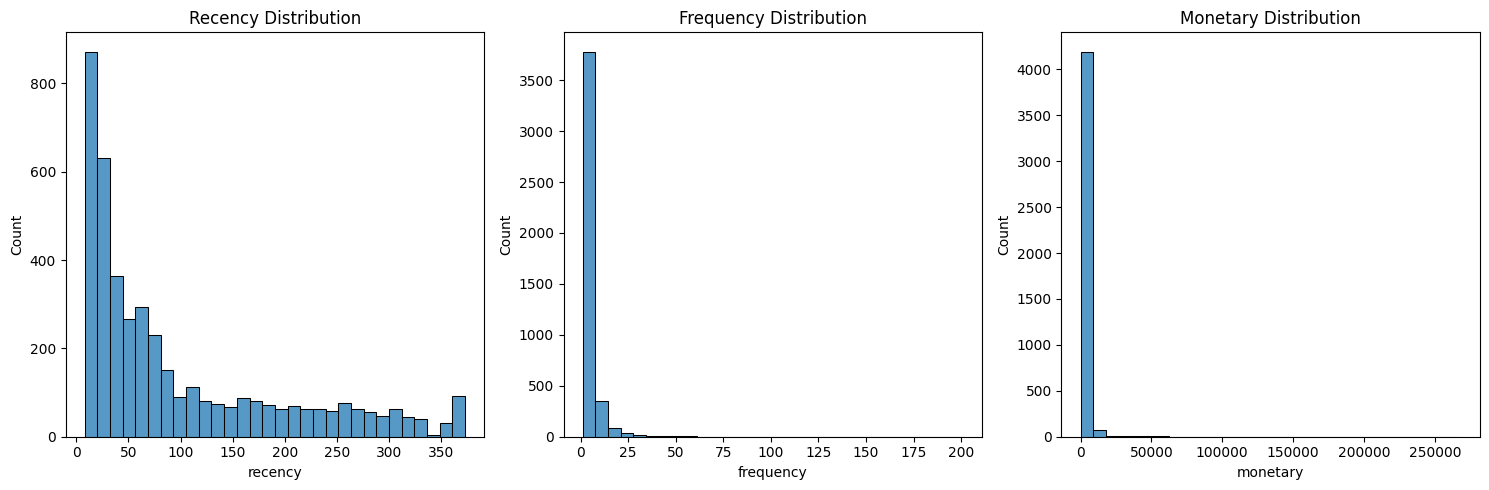

In [218]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=rfm, x='recency', bins=30, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(data=rfm, x='frequency', bins=30, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(data=rfm, x='monetary', bins=30, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

What's observed here:

* The recency distribution is right-skewed, indicating that the majority of customers made a resent purchase. However, there's a long tail representing customers who made purchases a long time ago.

* Both frequency and monetary distributions are right-skewed as well. They display one distinct prominent peak, making them unimodal distributions.
  * The frequency chart reveals a large group of customers with low frequency.
  * The monetary distribution follows a similar pattern. While some customers spent only a small amount, there's a smaller group that spent more.









**Mapping RFM values onto a 1-4 scale**


---



Now, I'm going to map the 'recency', 'frequency' and 'monetary' columns by assigning values to four different bins and mapping each bin to a value. To determine the bin edges, I will create buckets based on the quartile values of the 'recency', 'frequency' and 'monetary' columns.

Customers with the lowest recency, highest frequency and monetary will be considered as **top customers**.

In [219]:
rfm['r_score'] = pd.cut(rfm['recency'],
                        bins=[-1,
                              np.percentile(rfm['recency'], 25),
                              np.percentile(rfm['recency'], 50),
                              np.percentile(rfm['recency'], 75),
                              rfm['recency'].max()],
                        labels=[4, 3, 2, 1]).astype("int") # Reversing labels for recency
rfm['r_score'].value_counts().sort_index()

r_score
1    1076
2    1064
3    1081
4    1087
Name: count, dtype: int64

In [220]:
rfm['f_score'] = pd.cut(rfm['frequency'],
                          bins=[-1,
                                np.percentile(rfm['frequency'], 25),
                                np.percentile(rfm['frequency'], 50),
                                np.percentile(rfm['frequency'], 75),
                                rfm['frequency'].max()],
                          labels=[1, 2, 3, 4]).astype("int")
rfm['f_score'].value_counts().sort_index()

f_score
1    1534
2     814
3     898
4    1062
Name: count, dtype: int64

In [221]:
rfm['m_score'] = pd.cut(rfm['monetary'],
                         bins=[-1,
                               np.percentile(rfm['monetary'], 25),
                               np.percentile(rfm['monetary'], 50),
                               np.percentile(rfm['monetary'], 75),
                               rfm['monetary'].max()],
                         labels=[1, 2, 3, 4]).astype("int")
rfm['m_score'].value_counts().sort_index()

m_score
1    1077
2    1077
3    1077
4    1077
Name: count, dtype: int64

Now, I want to plot the distribution of customers based on their r_score, f_score and m_score.

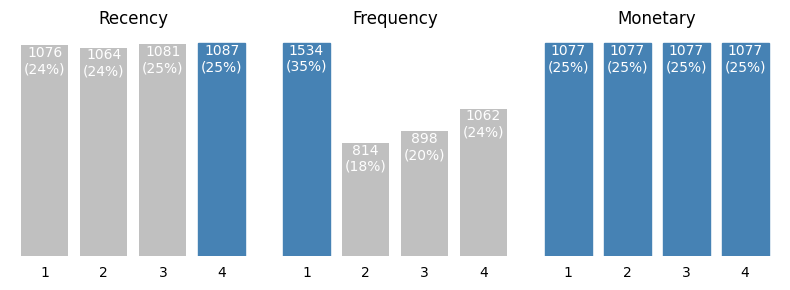

In [222]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for i, p in enumerate(['r_score', 'f_score', 'm_score']):
    parameters = {'r_score':'Recency', 'f_score':'Frequency', 'm_score':'Monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('{}'.format(parameters[p]),
                fontsize=12)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('#4682B4')
        # Adding text to each bar (its value and percentage of the total)
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.tight_layout()
plt.show()

What's observed here:
* Recency and Monetary appear to be evenly distributed.
* More than half of the customers don't purchase very often (53% of customers have a frequency of 1 or 2).

**RFM Customer Segmentation**


---



**Segments**

* **Champions** - bought recently, buy often and spend the most
* **Loyal Customers** - spend good money and often, responsive to promotions
* **Potential Loyalist** - recent customers, but spent a good amount and bought more than once
* **Recent Customers** - bought most recently, but not often
* **Promising** - recent shoppers, but haven’t spent much
* **Needing Attention** - above average recency, frequency and monetary values; may not have bought very recently though
* **About To Sleep** - below average recency, frequency and monetary values; will lose them if not reactivated
* **At Risk** - spent big money and purchased often, but long time ago; need to bring them back
* **Can't Loose Them** - made biggest purchases, and often, but haven’t returned for a long time
* **Hibernating** - last purchase was long back, low spenders and low number of orders
* **Lost** - lowest recency, frequency and monetary scores



I'm going to create a new column 'rfm_score', where I will concatenate the values from the 'r_score', 'f_score' and 'm_score' columns.

Then, I will assign customers to the segments based on their RFM scores.

In [223]:
rfm['rfm_score'] = rfm[['r_score', 'f_score', 'm_score']].astype(str).sum(axis=1)

In [224]:
rfm['rfm_segment'] = 'Uncategorized'

rfm.loc[rfm['rfm_score'].isin(['444', '344']), 'rfm_segment'] = 'Champions'
rfm.loc[rfm['rfm_score'].isin(['434', '334', '233']), 'rfm_segment'] = 'Loyal Customers'
rfm.loc[rfm['rfm_score'].isin(['443', '433', '424', '423', '343', '333', '324', '323']), 'rfm_segment'] = 'Potential Loyalists'
rfm.loc[rfm['rfm_score'].isin(['422', '421', '414', '413', '412', '411', '314', '313']), 'rfm_segment'] = 'Recent Customers'
rfm.loc[rfm['rfm_score'].isin(['442', '441', '432', '431', '342', '341', '332', '331', '322', '321', '312', '311']), 'rfm_segment'] = 'Promising Customers'
rfm.loc[rfm['rfm_score'] == '244', 'rfm_segment'] = 'Needing Attention'
rfm.loc[rfm['rfm_score'].isin(['231', '133', '132', '131', '123', '113', '232', '224', '223', '214', '242', '241', '142', '141', '124', '114']), 'rfm_segment'] = 'About to Sleep'
rfm.loc[rfm['rfm_score'].isin(['243', '234']), 'rfm_segment'] = 'At Risk'
rfm.loc[rfm['rfm_score'].isin(['144', '143', '134']), 'rfm_segment'] = "Can't Lose Them"
rfm.loc[rfm['rfm_score'].isin(['222', '221', '213', '212', '211', '122', '121', '112']), 'rfm_segment'] = 'Hibernating'
rfm.loc[rfm['rfm_score'] == '111', 'rfm_segment'] = 'Lost'

In [225]:
rfm.head()

,,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_segment
customer_id,country,,,,,,,,
12346,United Kingdom,325,1,"77,183.6",1,1,4,114,About to Sleep
12347,Iceland,39,6,"4,085.2",3,4,4,344,Champions
12348,Finland,75,4,"1,797.2",2,3,4,234,At Risk
12349,Italy,18,1,"1,757.5",4,1,4,414,Recent Customers
12350,Norway,310,1,334.4,1,1,2,112,Hibernating


I'm going to check if there are any missing values (customers without RFM segments assigned).

In [226]:
if rfm.isna().any().any():
    print("There are missing values in the DataFrame")
else:
    print("There are no missing values in the DataFrame")

There are no missing values in the DataFrame


I'm going to calculate how many customers are in each RFM segment and determine their share of the total.

In [227]:
customers_by_segment = rfm['rfm_segment'].value_counts().sort_values(ascending=True)

segment_info = pd.DataFrame({'Customers': customers_by_segment,
                             'Share (%)': (customers_by_segment / customers_by_segment.sum()) * 100})

# Defining custom sorting order based on the priority of the segment to the business
segment_order = {
    'Champions': 1,
    'Loyal Customers': 2,
    'Potential Loyalists': 3,
    'Recent Customers': 4,
    'Promising Customers': 5,
    'Needing Attention': 6,
    'About to Sleep': 7,
    'At Risk': 8,
    "Can't Lose Them": 9,
    'Hibernating': 10,
    'Lost': 11
}

segment_info_sorted = segment_info.reindex(sorted(segment_order, key=segment_order.get))
print(segment_info_sorted)

                     Customers  Share (%)
rfm_segment                              
Champions                  698       16.2
Loyal Customers            255        5.9
Potential Loyalists        585       13.6
Recent Customers           264        6.1
Promising Customers        509       11.8
Needing Attention          102        2.4
About to Sleep             412        9.6
At Risk                    106        2.5
Can't Lose Them             34        0.8
Hibernating                903       21.0
Lost                       440       10.2


I'd like to visualize this data.

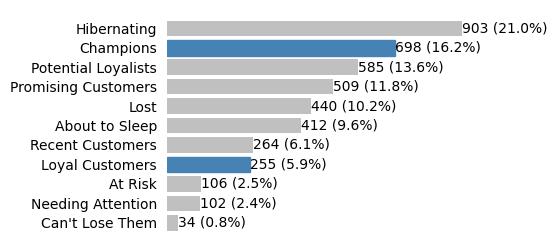

In [228]:
# Creating a horizontal bar plot showing the distribution of customers across RFM segments
plt.figure(figsize=(4, 3))

bars = plt.barh(range(len(customers_by_segment)),
                customers_by_segment,
                color='silver')
plt.gca().set_frame_on(False)
plt.gca().tick_params(left=False, bottom=False, labelbottom=False)
plt.yticks(range(len(customers_by_segment)), customers_by_segment.index)

for i, bar in enumerate(bars):
    value = bar.get_width()
    if customers_by_segment.index[i] in ['Champions', 'Loyal Customers']:
        bar.set_color('#4682B4')
    plt.text(value,
             bar.get_y() + bar.get_height()/2,
             '{:,} ({:.1f}%)'.format(int(value), value * 100 / customers_by_segment.sum()),
             va='center',
             ha='left')

plt.show()

What's observed here:

The majority of customers are in the 'Hibernating' segment (20.9%), followed by 'Champions' with 16.2%.

The lowest number of customers are assigned to the 'Can't lose them', 'Needing Attention' and 'At Risk' segments.

I'm going to calculate aggregated metrics for each RFM segment, including total sales, average recency, average frequency and average monetary. This analysis will help evaluate each segment's value to the business.



In [229]:
segments_agg = rfm.groupby('rfm_segment').agg({
                                              'recency': 'mean',
                                              'frequency': 'mean',
                                              'monetary': ['sum', 'mean']
                                              }).round(1)

segments_sorted = segments_agg.reindex(sorted(segment_order, key=segment_order.get))

recency_df = segments_sorted['recency'].rename(columns={'mean': 'Avg Recency'})
frequency_df = segments_sorted['frequency'].rename(columns={'mean': 'Avg Frequency'})
monetary_df = segments_sorted['monetary']['mean'].rename('Avg Monetary')
revenue_df = segments_sorted['monetary']['sum'].rename('Revenue')

segments_df = pd.concat([revenue_df, recency_df, frequency_df, monetary_df], axis=1)

total_revenue = segments_df['Revenue'].astype(float).sum()
segments_df['Revenue (%)'] = (segments_df['Revenue'].astype(float) / total_revenue) * 100

segments_df = segments_df[['Revenue', 'Revenue (%)', 'Avg Recency', 'Avg Frequency', 'Avg Monetary']]

print("\nSegments Metrics Summary:")
print(segments_df)


Segments Metrics Summary:
                        Revenue  Revenue (%)  Avg Recency  Avg Frequency  \
rfm_segment                                                                
Champions           5,385,329.2         64.0         22.0           13.2   
Loyal Customers       458,898.3          5.5         62.5            3.5   
Potential Loyalists   657,020.4          7.8         26.3            4.0   
Recent Customers      115,811.1          1.4         19.5            1.4   
Promising Customers   181,586.0          2.2         35.9            1.9   
Needing Attention     317,638.0          3.8         82.3            7.2   
About to Sleep        487,705.1          5.8        163.2            2.5   
At Risk               222,421.0          2.6         89.8            4.5   
Can't Lose Them       170,597.7          2.0        217.6            6.7   
Hibernating           346,347.8          4.1        159.4            1.3   
Lost                   71,069.1          0.8        269.7    

What's observed here:

* '**Champions**', '**Loyal Customers**' and '**Potential Loyalists**' together constitute around one-third of all customers (35.7%), generating 77% of the sales.
* The '**Champions**' are our most valuable and profitable cutomers, comprising 16.2% of all customers and generating 64% of all sales.
* Although '**Potential Loyalists**' are not as active as 'Champions', they show potential for becoming long-term, high-value customers with 13.6% of all customers and 7.8% of revenue.
* It is a risk that the '**Hibernating**' group is so substantial - almost 21% of all customers. There is an opportunity to potentially reactivate some of this group through targeted outreach campaigns and convert them to more profitable segments.
* The marketing team should also focus on the '**About to Sleep**' group to improve customer retention, as they currently contribute 5.8% of total sales.

This graph shows the distribution of our customers based on their average recency, frequency and monetary.

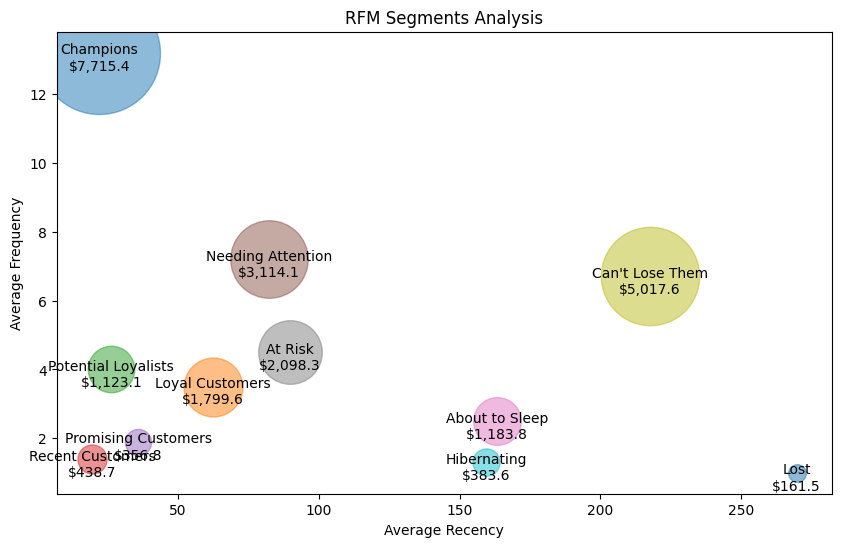

In [230]:
bubble_size = segments_df['Avg Monetary']

plt.figure(figsize=(10, 6))
for segment in segments_df.index:
    plt.scatter(segments_df.loc[segment, 'Avg Recency'], segments_df.loc[segment, 'Avg Frequency'],
                s=bubble_size[segment], alpha=0.5)
    label = f"{segment}\n${segments_df.loc[segment, 'Avg Monetary']:,}"
    plt.text(segments_df.loc[segment, 'Avg Recency'], segments_df.loc[segment, 'Avg Frequency'] - 0.5,
             label, ha='center')

plt.xlabel('Average Recency')
plt.ylabel('Average Frequency')
plt.title('RFM Segments Analysis')

plt.show()

What's observed here:

* '**Champions**' are those who buy most often and have made their last order recently.
* '**Recent Customers**' and '**Promising Customers**' made purchases not long ago but are not yet frequent buyers.
* '**Can't Lose Them**' are low in number but significant revenue contributors.
* '**Lost**' customers have the lowest recency and frequency scores.

Let's take a closer look at the distribution of the segments we want to focus on.

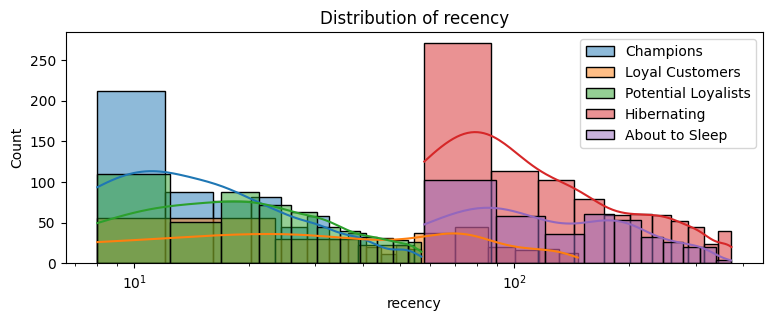

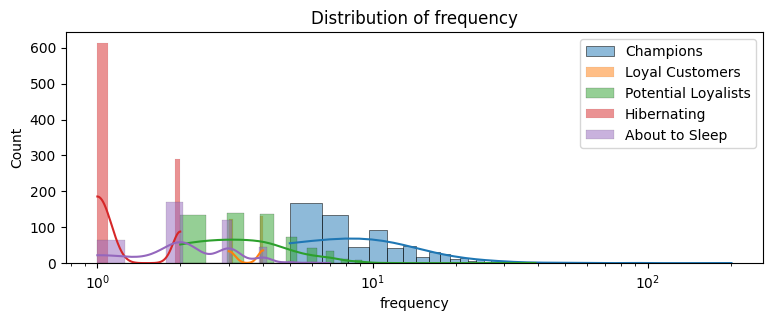

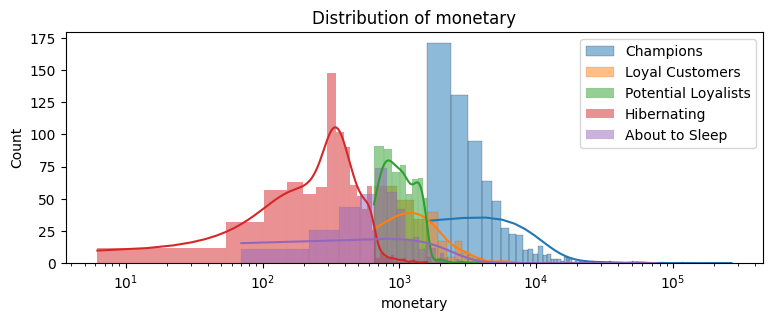

In [231]:
colnames = ['recency', 'frequency', 'monetary']
segments = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'Hibernating', 'About to Sleep']

for col in colnames:
    plt.figure(figsize=(9, 3))
    for segment in segments:
        data = rfm[rfm['rfm_segment'] == segment][col]
        if not data.empty:
            sns.histplot(data, kde=True, label=segment)
    plt.title('Distribution of %s' % col)
    plt.legend()
    plt.xscale('log') # Setting logarithmic scale on x-axis to reduce the skewness and make the distributions more interpretable
    plt.show()

What's observed here:

These distributions suggest that there are visible differences between different segments of customers. By examining the distribution of segments such as 'Champions', 'Loyal Customers', 'Potential Loyalists', 'Hibernating' and 'About to Sleep', it's noticeble that they constitute different portions of the total distribution. For example, 'Hibernating' customers are responsible for first monetary peak, while 'Champions' are responsible for the second.


**Recommendations**


---



* High-Value Customers:

 * Champions: Recent, frequent customers who contribute significantly to revenue. They promote the brand and new products.
 * Loyal Customers: Less frequent but longstanding customers who add up to a substantial revenue share. They respond well to promotions and loyalty rewards.

* Potential Growth Segments:

 * Potential Loyalists: Show potential for becoming long-term, high-value customers. They respond well to loyalty programs and memberships.
 * Recent Customers: Recently started buying; need onboarding support to increase frequency and value.

* Engagement Opportunities:

 * Promising Customers: Show frequency potential but low monetary contribution.
 * Needing Attention: High-frequency, high-value customers showing signs of decreased activity.
 * At Risk: Show signs of decreasing frequency and monetary value. Opportunity for targeted engagement strategies aimed at retaining their interest and loyalty.

* Reactivation Targets:

 * About to Sleep: Inactive for some time, need re-engagement strategies.
 * Can't Lose Them: Low in number but significant revenue contributors; need retention efforts.
 * Hibernating: Inactive for a while, but represent a target for reactivation campaigns.

* Lost Opportunities:

 * Lost Customers: Inactive for an extended period, challenging to re-engage.


**Conclusion**

---



By understanding the unique needs and behaviors of each segment, we can tailor our approach to maximize customer engagement, satisfaction and, ultimately, revenue growth. RFM segmentation is a powerful tool to guide our marketing and operational decisions for a more customer-centric and effective business strategy.